In [1]:
import os
import sys

repo_root_path = os.path.abspath(os.path.join(os.path.pardir, 'hebbnets'))
if repo_root_path not in sys.path:
    sys.path.append(repo_root_path)

import matplotlib.pyplot as plt
%matplotlib nbagg

import numpy as np

from demo_utils import yeild_patch_batch, turn_input_weights_to_pilimg, place_pilimgs_in_grid
from hebbnets.hebbnets.hah_model import MultilayerHahNetwork

# Make image patch generator

In [2]:
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/3/39/GlarusAlps.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/38/M_Rainier.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/3c/Volc%C3%A1n_Chimborazo%2C_%22El_Taita_Chimborazo%22.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/0/06/Briesetal_bei_Briese.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/7/75/Florida_freshwater_swamp_usgov_image.jpg'
]

patch_size = [12, 12]

batch_o_patches_gen = yeild_patch_batch(
    image_urls,
    patch_size=patch_size,
    patch_stride=[9, 9],
    batch_size=5000
)

# Set up HAH network

In [3]:
input_layer_size = patch_size[0] * patch_size[1]
nodes_per_layer = [196]

hah_network = MultilayerHahNetwork(
    input_layer_size,
    nodes_per_layer,
    has_bias=False,
    act_type='soft_thresh',
    reg_lambda=2.0,
    noise_var=0.01
)

# Gather/whiten all patches

In [4]:
all_patches = np.vstack([
    np.array([p.ravel() / 255.0 for p in batch])
    for batch in batch_o_patches_gen
])

In [5]:
# Whitening image patches
all_patches -= all_patches.ravel().mean()
cov_mat = all_patches.T.dot(all_patches) / all_patches.shape[0]
whiten_mat = np.linalg.pinv(cov_mat + 0.01 * np.eye(cov_mat.shape[0]))
dewhiten_mat = np.linalg.pinv(whiten_mat)
all_patches_white = all_patches.dot(whiten_mat)

# Train network on batches of patches

In [6]:
hah_network.train(
    all_patches_white,
    num_epochs=3
)

# Visualize the learned recpetive fields

In [7]:
rf_picture = place_pilimgs_in_grid(
    turn_input_weights_to_pilimg(
        hah_network.layers[0],
        patch_size,
        dewhiten_mat
    )
)

In [8]:
hah_network.layers[0]._soft_thresh_val

array([1.02301096e-05, 1.16992098e-05, 3.42096158e-05, 1.75758269e-05,
       1.96163691e-05, 8.30391086e-05, 2.25910058e-05, 6.40874317e-06,
       5.10058366e-05, 8.31120817e-06, 5.66159032e-05, 7.84128430e-06,
       1.74251009e-05, 6.87579945e-05, 4.69748885e-05, 4.18395114e-05,
       9.01540549e-06, 9.54639399e-06, 3.12199039e-06, 1.68117334e-05,
       1.77637573e-05, 5.81573677e-05, 5.59018185e-05, 5.27910322e-05,
       1.03949653e-05, 4.58194467e-05, 1.90763169e-05, 1.69975669e-05,
       3.77212056e-06, 1.30854683e-05, 1.84881012e-05, 2.32940136e-05,
       7.80952498e-06, 6.30950160e-05, 5.30585784e-05, 3.41380051e-06,
       4.68125063e-05, 3.97925708e-05, 9.86599359e-05, 2.82470722e-05,
       7.79538737e-05, 6.78805939e-05, 3.59763195e-05, 5.87839861e-05,
       5.89066208e-05, 2.97359788e-05, 9.02934381e-06, 5.05248067e-05,
       2.24826427e-05, 2.96494484e-05, 4.71075431e-05, 1.01446731e-05,
       4.60133691e-06, 2.39150765e-05, 1.32468141e-05, 4.65596643e-05,
      

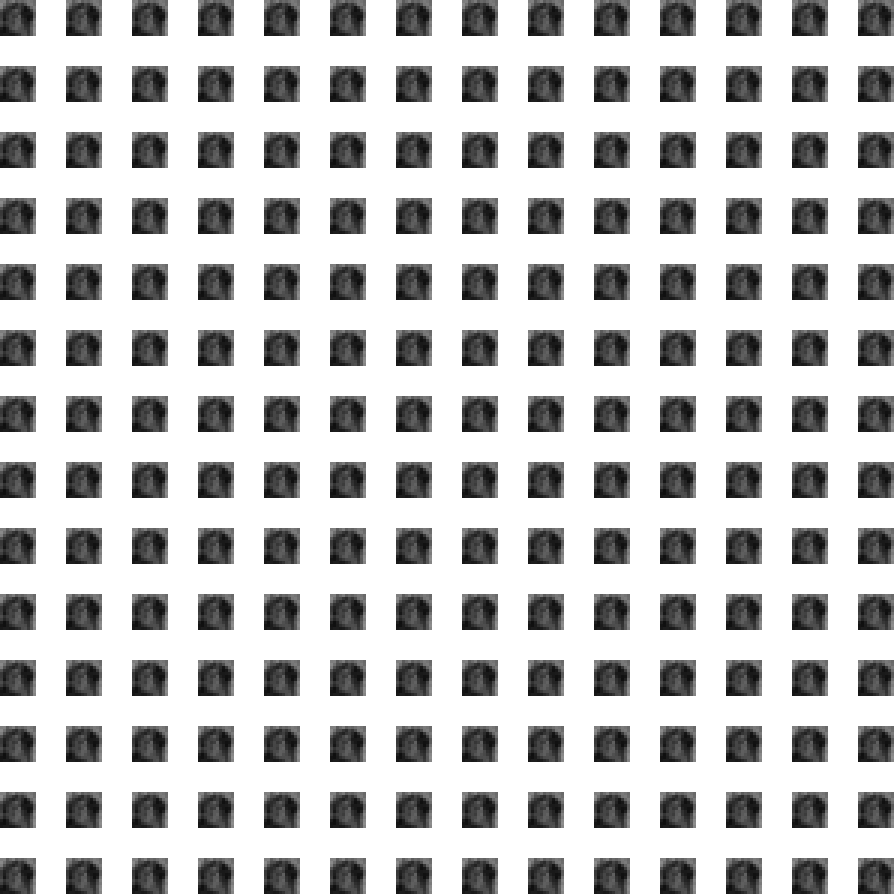

In [9]:
img_rescale = 3.0

rf_picture.resize(
    [int(img_rescale * i) for i in rf_picture.size],
)